In [1]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

c:\Users\User\anaconda3\envs\Zillow\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_Mar__8_18:36:24_Pacific_Standard_Time_2022
Cuda compilation tools, release 11.6, V11.6.124
Build cuda_11.6.r11.6/compiler.31057947_0
torch:  1.13 ; cuda:  1.13.1
detectron2: 0.6


In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
# Some basic setup:
# Setup detectron2 logger
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultTrainer

import os, pickle

config_file_path="COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
checkpoint_url ="COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"

output_dir = "./output"

num_class = 8; #TODO:類別數量
device = "cuda"

train_dataset_name = "sb_train"
train_images_path = "./train/images"
train_json_annot_path = "./train/result.json"

test_dataset_name="sb_test"
test_images_path="./test/images"
test_json_annot_path="./test/result.json"
cfg_save_path ="./output/cfg.pickele"
#註冊資料集
register_coco_instances(name=train_dataset_name , metadata={} , json_file=train_json_annot_path , image_root= train_images_path)
register_coco_instances(name=test_dataset_name , metadata={} , json_file=test_json_annot_path , image_root= test_images_path)

#from detectron2.detectron2.utils.logger import setup_logger

WARNING [01/26 00:25:38 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[01/26 00:25:38 d2.data.datasets.coco]: Loaded 70 images in COCO format from ./train/result.json
d:\Code4Practice\StarBurst_Detectron2\train\images\af345ba3-LINE_ALBUM_StarBurst_221213_6.jpg


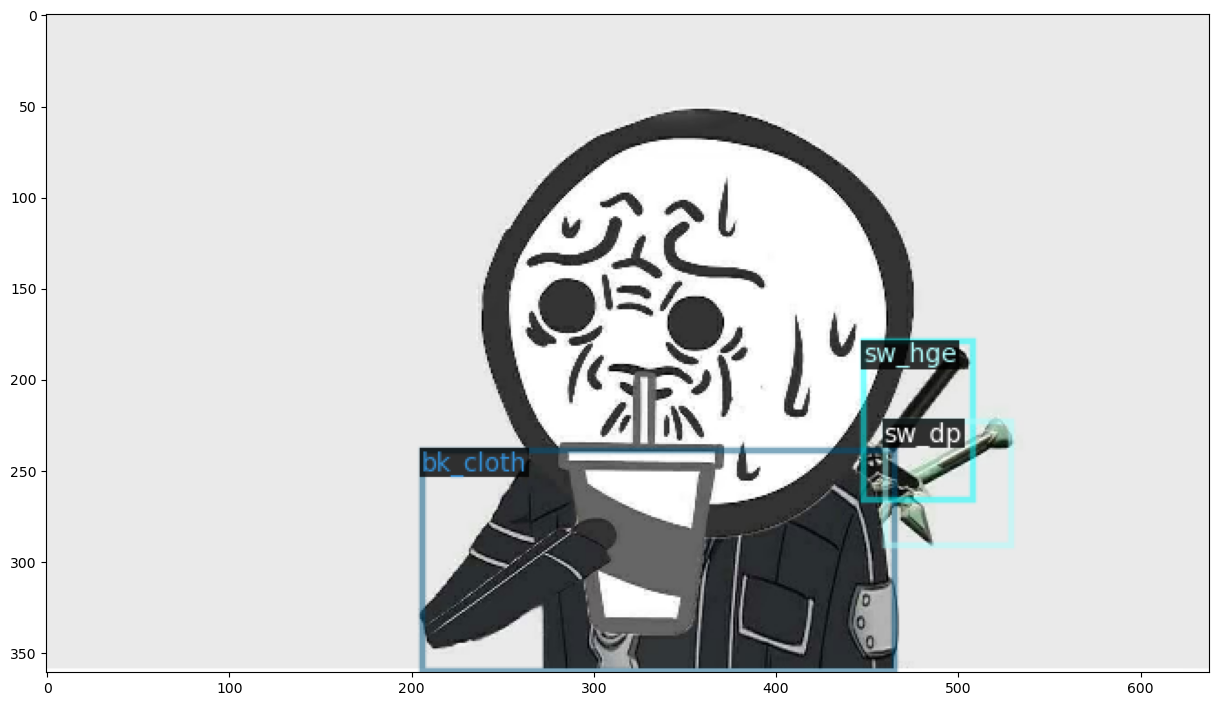

d:\Code4Practice\StarBurst_Detectron2\train\images\9f7b8191-LINE_ALBUM_StarBurst_230125_42.jpg


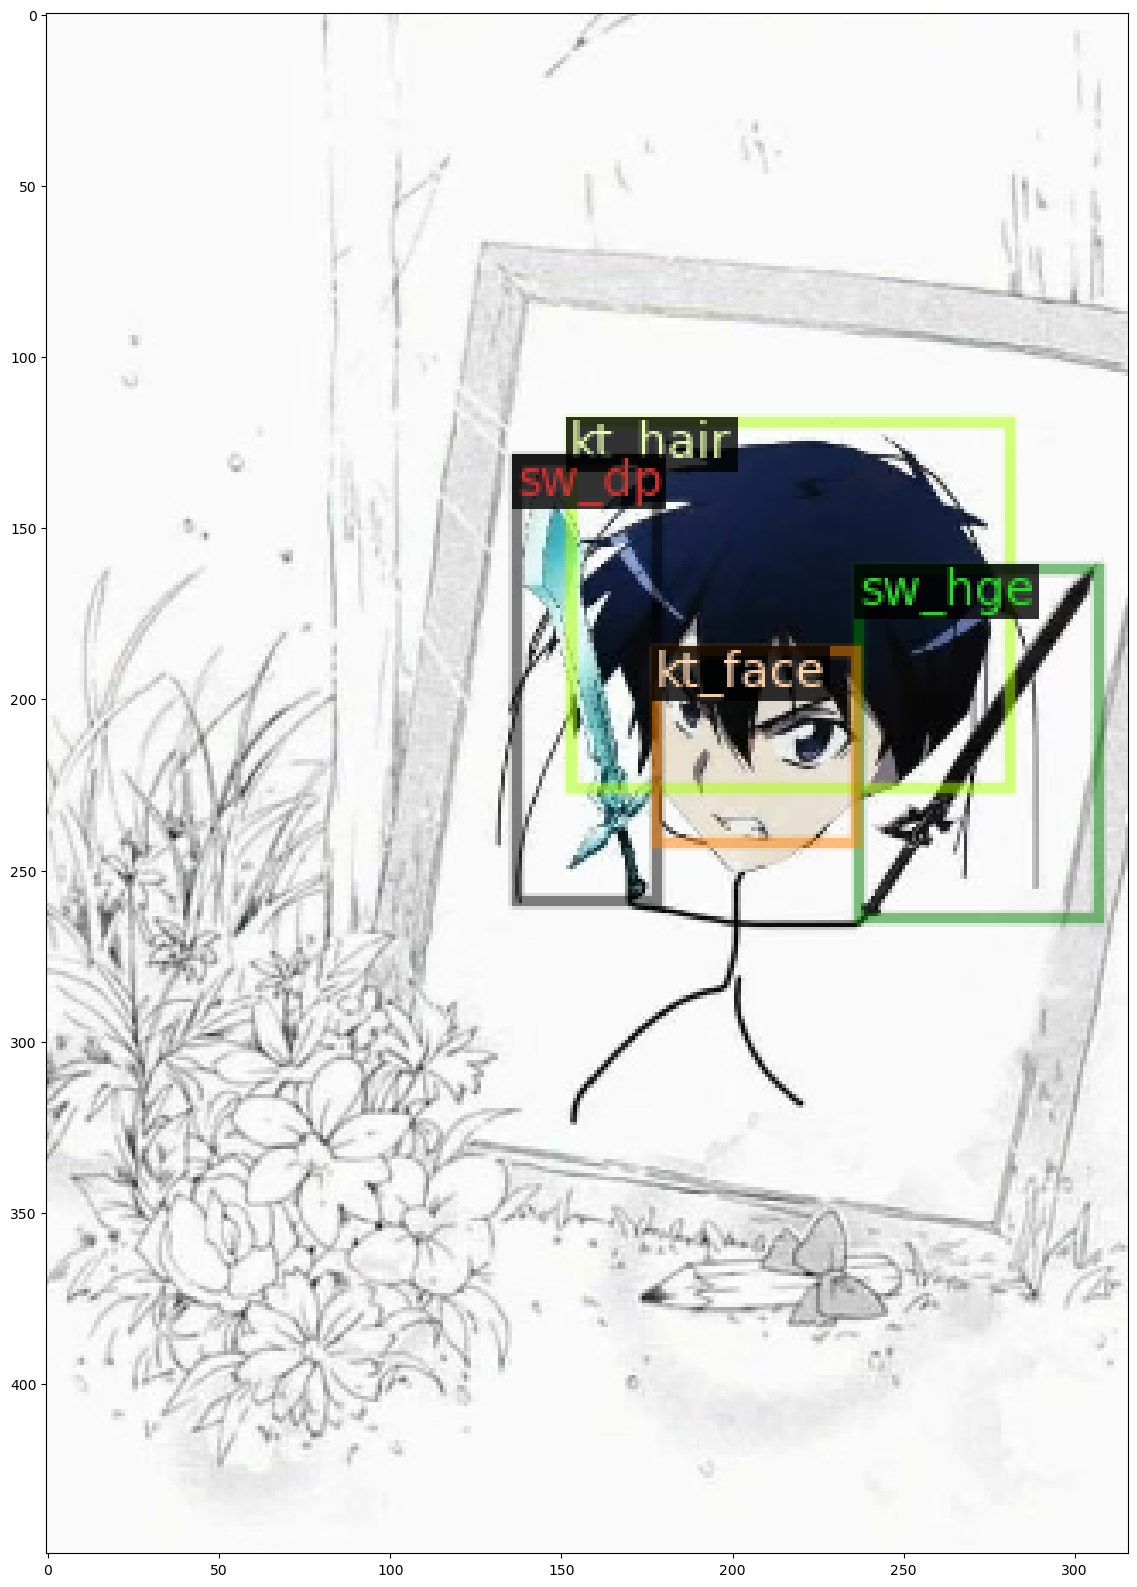

In [4]:
#顯示train的資料
from utils import *
plot_samples(dataset_name=train_dataset_name , n=2)

In [5]:
# 定義Trainner:
from detectron2.data import build_detection_train_loader
from detectron2.data import detection_utils as utils
def mapper(dataset_dict):
        img_path = os.path.join( os.getcwd(),"train","images",os.path.basename( dataset_dict["file_name"]))
        
        image = cv2.imread(img_path)
        image = torch.from_numpy(image.transpose(2, 0, 1))  # torch.Size([780, 1152, 3]) => torch.Size([3, 780, 1152])
        annos =dataset_dict.pop("annotations")
        print(annos)
        datas = dataset_dict.copy()
        datas['image'] =image
        datas['instances'] =  utils.annotations_to_instances(annos, image.shape[1:])
        '''
        return {
        # create the format that the model expects
        "image": image,
        #"instances": utils.annotations_to_instances(annos, image.shape[1:])
        "instances": utils.annotations_to_instances(annos, image.shape[1:])
        }
        '''
        return datas
        

class TrainerEnhance(DefaultTrainer):
    def __init__(self, cfg):
        super().__init__(cfg)
    @classmethod
    def build_train_loader(cls, cfg):
        '''
        if cfg.INPUT.ENHANCE_IMAGE:
            mapper = DatasetMapper(cfg, is_train=True, augmentations=[map_enhance])
        else:
            mapper = None
        return build_detection_train_loader(cfg, mapper=mapper)
        '''
        return build_detection_train_loader(cfg, mapper=mapper)


In [6]:
#cfg=get_train_cfg(config_file_path , checkpoint_url , train_dataset_name, test_dataset_name , num_class , device , output_dir)
data_dict = DatasetCatalog.get(train_dataset_name)

data = mapper(data_dict[0])
print(data_dict[0].keys())
print()
print(data.keys())
print(data['instances'])

print(data['image'].shape) #

WARNING [01/26 00:25:38 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[01/26 00:25:38 d2.data.datasets.coco]: Loaded 70 images in COCO format from ./train/result.json
[{'iscrowd': 0, 'bbox': [2, 206, 303, 690], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [27, 108, 139, 119], 'category_id': 2, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [3, 4, 210, 180], 'category_id': 3, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [612, 819, 149, 41], 'category_id': 7, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}]
dict_keys(['file_name', 'height', 'width', 'image_id'])

dict_keys(['file_name', 'height', 'width', 'image_id', 'image', 'instances'])
Instances(num_instances=4, image_height=900, image_width=900, fields=[gt_boxes: Boxes(tensor([[  2., 206., 305., 896.],
        [ 27., 108., 166., 227.],
        [  3.,   4., 213., 184.],
        [612., 819., 761., 860.]])), gt_classes: 

In [7]:
#非必要: wandb監測
import wandb
import random

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="StarBurstDetection",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.00025,
    "architecture": "Detectron2",
    "dataset": train_dataset_name,
    "epochs": 1000,
    },
    sync_tensorboard=True
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: lontoone. Use `wandb login --relogin` to force relogin


In [8]:
#建立Trainer
cfg=get_train_cfg(config_file_path , checkpoint_url , train_dataset_name, test_dataset_name , num_class , device , output_dir)
    
with open(cfg_save_path ,  'wb') as f: 
    pickle.dump(cfg , f , protocol=pickle.HIGHEST_PROTOCOL)
os.makedirs(cfg.OUTPUT_DIR , exist_ok=True)
trainer = TrainerEnhance(cfg)
trainer.resume_or_load(resume=True)
    
trainer.data_loader

[01/26 00:25:44 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [9]:
trainer.train()

[01/26 00:25:44 d2.engine.train_loop]: Starting training from iteration 1000


c:\Users\User\anaconda3\envs\Zillow\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[01/26 00:26:13 d2.utils.events]:  eta: 0:54:04  iter: 1019  total_loss: 0.4762  loss_cls: 0.1647  loss_box_reg: 0.2712  loss_rpn_cls: 0.00451  loss_rpn_loc: 0.01515  time: 1.2623  data_time: 0.1359  lr: 0.00025  max_mem: 3308M
[01/26 00:26:50 d2.utils.events]:  eta: 1:06:41  iter: 1039  total_loss: 0.3711  loss_cls: 0.1569  loss_box_reg: 0.2044  loss_rpn_cls: 0.004235  loss_rpn_loc: 0.01225  time: 1.5725  data_time: 0.0013  lr: 0.00025  max_mem: 3308M
[01/26 00:27:18 d2.utils.events]:  eta: 1:11:45  iter: 1059  total_loss: 0.4919  loss_cls: 0.1841  loss_box_reg: 0.2792  loss_rpn_cls: 0.004127  loss_rpn_loc: 0.01419  time: 1.5086  data_time: 0.0013  lr: 0.00025  max_mem: 3308M
[01/26 00:28:16 d2.utils.events]:  eta: 1:17:00  iter: 1079  total_loss: 0.3564  loss_cls: 0.1328  loss_box_reg: 0.2118  loss_rpn_cls: 0.003676  loss_rpn_loc: 0.01808  time: 1.8669  data_time: 0.0015  lr: 0.00025  max_mem: 3308M
[01/26 00:28:46 d2.utils.events]:  eta: 1:12:05  iter: 1099  total_loss: 0.4447  loss

KeyboardInterrupt: 

In [10]:
def on_image(image_path , predictor):
    im = cv2.imread(image_path)
    #print(im==None)
    output = predictor(im)
    print(output)
    v = Visualizer(im[:,:,::-1] , metadata=MetadataCatalog.get(train_dataset_name) ,instance_mode=ColorMode.SEGMENTATION , scale=0.5) #deteron2 need RGB format. use ::-1 to swap red and blue channel
    v = v.draw_instance_predictions(output["instances"].to("cpu"))
    
    #Get class name
    pred_classes = output['instances'].pred_classes.cpu().tolist()
    class_names = MetadataCatalog.get(train_dataset_name).thing_classes
    pred_class_names = list(map(lambda x: class_names[x], pred_classes))

    
    plt.figure(figsize=(14,10))
    plt.imshow(v.get_image())
    plt.show()
    

In [11]:
# Use the app
from detectron2.engine import DefaultPredictor

import os
import pickle

from utils import *
with open(cfg_save_path, 'rb') as f:
    cfg =pickle.load(f)
    
cfg.MODEL.WEIGHTS= os.path.join(cfg.OUTPUT_DIR , "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 #超過這個值就會display
predictor = DefaultPredictor(cfg)


[01/26 00:34:02 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output\model_final.pth ...


{'instances': Instances(num_instances=2, image_height=886, image_width=1920, fields=[pred_boxes: Boxes(tensor([[ 710.5812,  364.0315,  866.8427,  530.6680],
        [ 677.0319,  289.0856, 1284.7498,  567.8521]], device='cuda:0')), scores: tensor([0.9857, 0.6116], device='cuda:0'), pred_classes: tensor([2, 2], device='cuda:0')])}


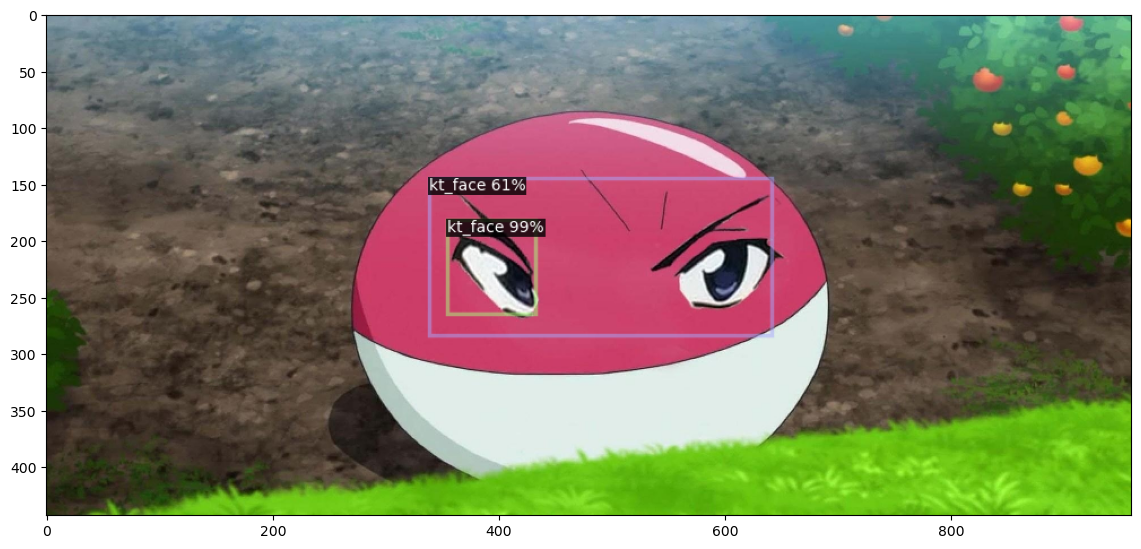

In [12]:

#on_image(r"C:\Users\User\Downloads\sb_pig.png" , predictor)
#on_image(r"C:\Users\User\Downloads\280378147_423300919619769_4098910756880552943_n.png" , predictor)
on_image(r"C:\Users\User\Downloads\LINE_ALBUM_StarBurst_221213_654.jpg" , predictor)

D:\BigData\LINE_ALBUM_StarBurst_230125_71.jpg
{'instances': Instances(num_instances=1, image_height=506, image_width=900, fields=[pred_boxes: Boxes(tensor([[512.0226, 142.5637, 616.1357, 188.0216]], device='cuda:0')), scores: tensor([0.7749], device='cuda:0'), pred_classes: tensor([2], device='cuda:0')])}


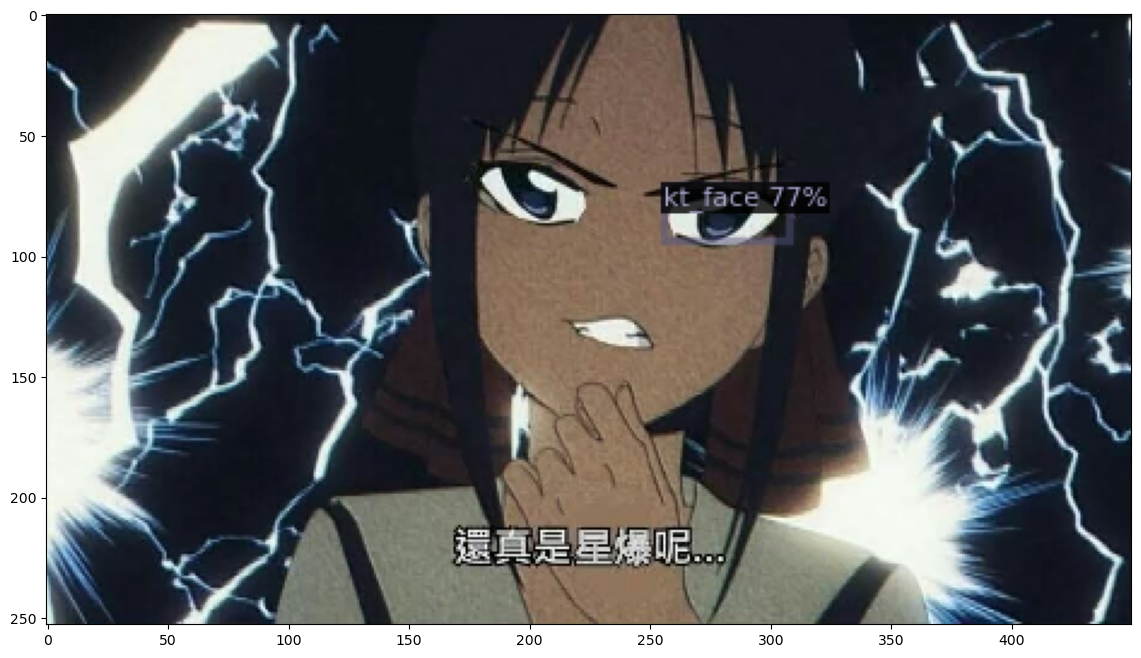

D:\BigData\LINE_ALBUM_StarBurst_230125_664.jpg
{'instances': Instances(num_instances=0, image_height=2048, image_width=1528, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64)])}


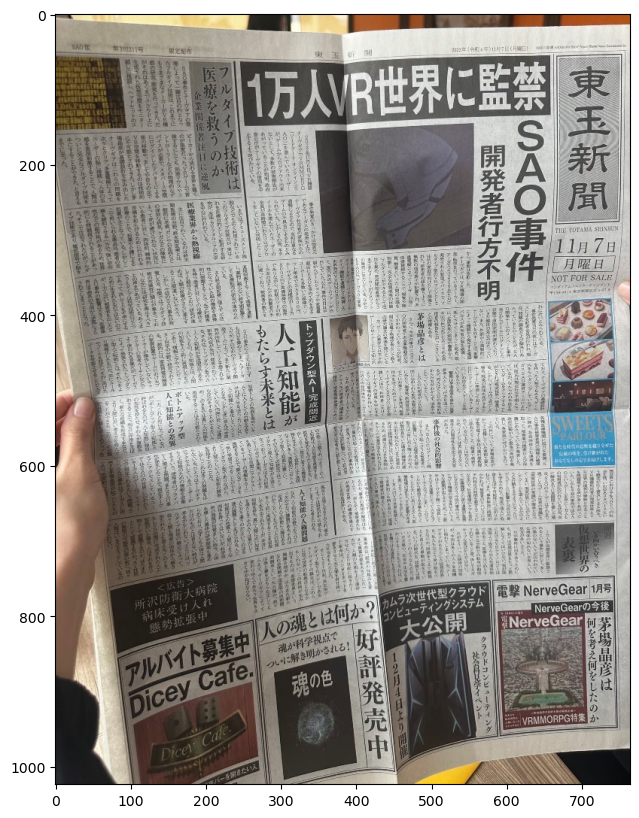

D:\BigData\LINE_ALBUM_StarBurst_230125_379.jpg
{'instances': Instances(num_instances=0, image_height=500, image_width=396, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64)])}


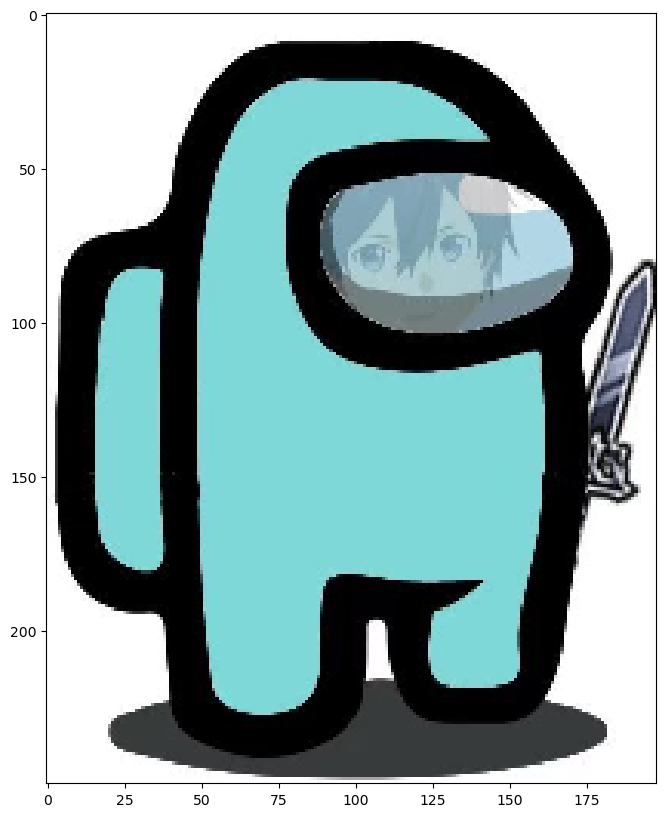

D:\BigData\LINE_ALBUM_StarBurst_230125_367.jpg
{'instances': Instances(num_instances=3, image_height=580, image_width=1030, fields=[pred_boxes: Boxes(tensor([[577.2752,   2.4150, 770.1610, 171.0128],
        [633.1721, 100.2856, 726.6506, 193.3944],
        [280.4146,  91.6776, 347.2216, 162.2756]], device='cuda:0')), scores: tensor([0.8646, 0.7753, 0.6486], device='cuda:0'), pred_classes: tensor([3, 2, 2], device='cuda:0')])}


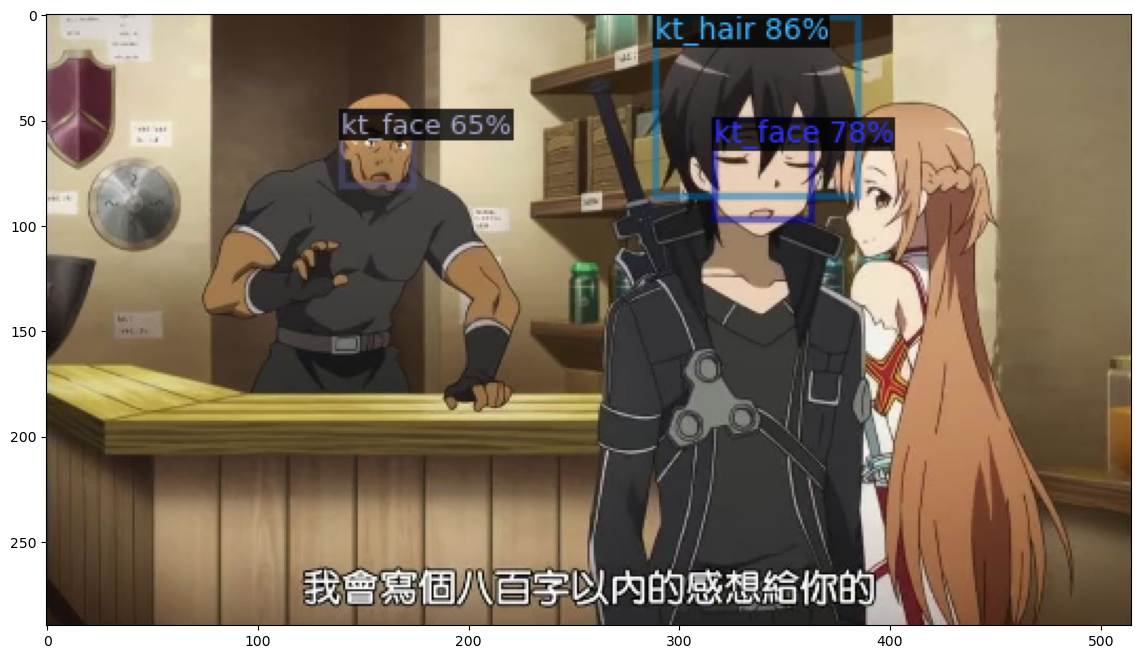

D:\BigData\LINE_ALBUM_StarBurst_230125_364.jpg
{'instances': Instances(num_instances=1, image_height=420, image_width=560, fields=[pred_boxes: Boxes(tensor([[357.4225, 102.0830, 507.1470, 291.0191]], device='cuda:0')), scores: tensor([0.8721], device='cuda:0'), pred_classes: tensor([2], device='cuda:0')])}


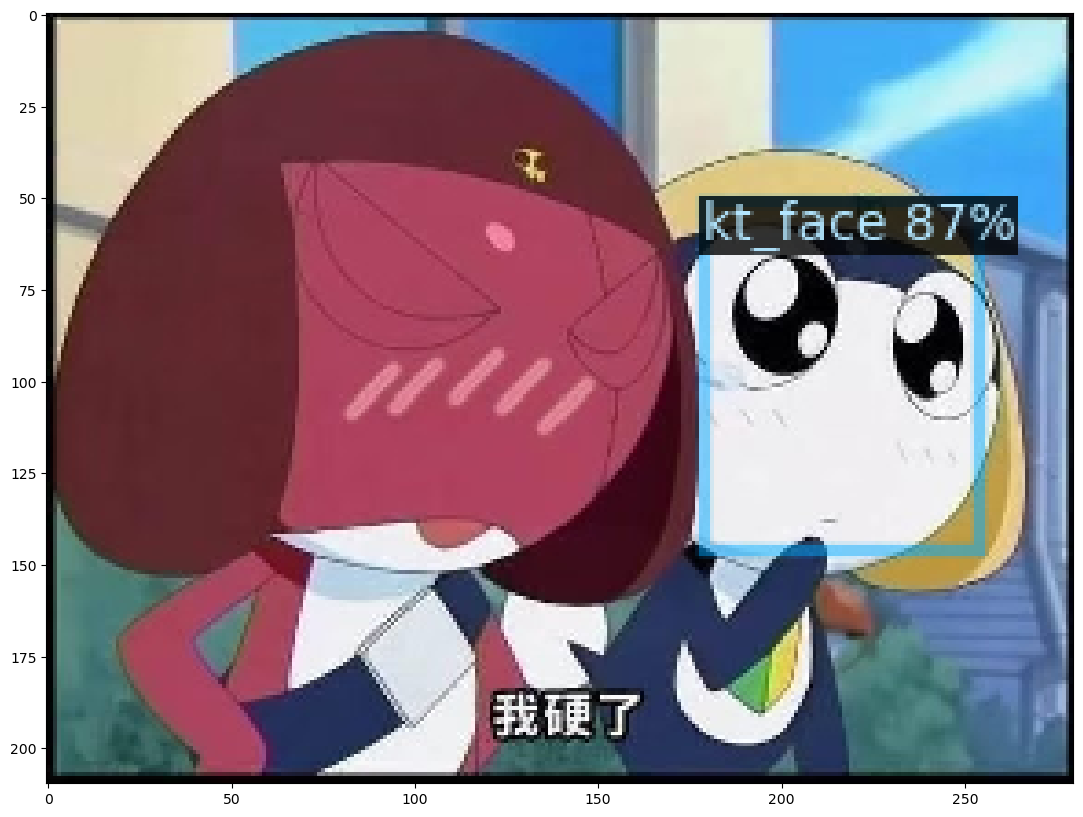

In [15]:
for s in range(0,5):
    import os, random
    root=r"D:\BigData"
    img_path = random.choice(os.listdir(root))
    img_path = os.path.join(root , img_path)
    print(img_path)
    on_image(img_path , predictor)